## 環境初始化
新增 [gym-anytrading](https://github.com/AminHP/gym-anytrading) 套件，當作本次任務的環境。

In [1]:
!pip install gym-anytrading

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


引入需要的套件，並設定隨機參數種子。

In [2]:
import gym
import gym_anytrading
from gym_anytrading.envs import TradingEnv, StocksEnv, Actions, Positions 

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

import os
import pandas as pd

# 設定 seed
torch.manual_seed(1234)
np.random.seed(1234)

## 使用自訂資料集
本次作業同樣使用台積電 (2330) 2010/1月~2022/10月資料作為使用的內容。

In [3]:
STOCKS_TSMC = pd.read_csv('./2330_stock.csv')
STOCKS_TSMC

,Datetime,Shares,Amount,Open,High,Low,Close,Change,Turnover
0,2010-01-04,39511138,2557720928,65.0,65.0,64.0,64.9,0.4,8255.0
1,2010-01-05,38394084,2464115096,65.0,65.1,63.9,64.5,-0.4,9205.0
2,2010-01-06,52734385,3390698544,64.5,64.9,63.7,64.9,0.4,12597.0
3,2010-01-07,53294614,3437221996,64.9,65.0,64.2,64.2,-0.7,11195.0
4,2010-01-08,48047497,3068341466,63.5,64.3,63.5,64.0,-0.2,9804.0
...,...,...,...,...,...,...,...,...,...
3143,2022-10-13,43158592,17239718998,400.5,403.0,395.0,395.0,-2.5,66846.0
3144,2022-10-14,59841064,24714069328,414.5,416.0,409.0,412.0,17.0,54666.0
3145,2022-10-17,45038159,17954868983,400.0,403.5,396.0,397.0,-15.0,66589.0
3146,2022-10-18,41304834,16675510801,406.5,407.0,399.5,407.0,10.0,30538.0


將台積電資料輸入股票環境，並設定本次環境範圍與輸入天數資料 (欄位內容、天數等)。


In [4]:
def my_process_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    # 這邊可自訂想要使用的 feature
    signal_features = env.df.loc[:, ['Close', 'Open']].to_numpy()[start:end]
    return prices, signal_features


class MyStocksEnv(StocksEnv):
    _process_data = my_process_data

# window_size: 能夠看到幾天的資料當作輸入, frame_bound: 想要使用的資料日期區間
env = MyStocksEnv(df=STOCKS_TSMC, window_size=10, frame_bound=(1000, 1500))

檢視環境參數

env information:
> shape: (10, 2)
> df.shape: (3148, 9)
> prices.shape: (510,)
> signal_features.shape: (510, 2)
> max_possible_profit: 13.477262444760823


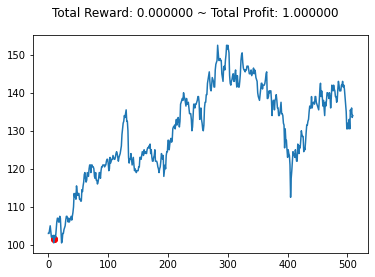

In [5]:
print("env information:")
print("> shape:", env.shape)
print("> df.shape:", env.df.shape)
print("> prices.shape:", env.prices.shape)
print("> signal_features.shape:", env.signal_features.shape)
print("> max_possible_profit:", env.max_possible_profit())

env.reset()
env.render()

{'total_reward': 10.0, 'total_profit': 0.16069573300607962, 'position': 1}


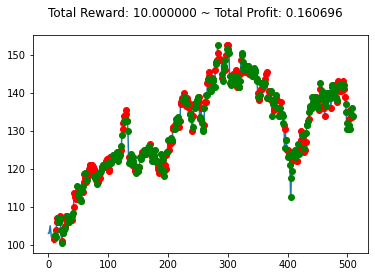

In [6]:
observation = env.reset()

while True:
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        print(info)
        break

plt.cla()
env.render_all()
plt.show()

## Policy Gradient

現在來搭建一個簡單的 policy network。
我們預設模型的輸入是 20-dim (10天*2欄位) 的 observation，輸出則是離散的二個動作之一 (賣=0 或 買=1)

In [7]:
class PolicyGradientNetwork(nn.Module):

    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 2)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        return F.softmax(self.fc3(hid), dim=-1)

再來，搭建一個簡單的 agent，並搭配上方的 policy network 來採取行動。
這個 agent 能做到以下幾件事：
- `learn()`：從記下來的 log probabilities 及 rewards 來更新 policy network。
- `sample()`：從 environment 得到 observation 之後，利用 policy network 得出應該採取的行動。
而此函式除了回傳抽樣出來的 action，也會回傳此次抽樣的 log probabilities。

In [8]:
class PolicyGradientAgent():

    def __init__(self, network):
        self.network = network
        self.optimizer = optim.SGD(self.network.parameters(), lr=0.001)

    def learn(self, log_probs, rewards):
        loss = (-log_probs * rewards).sum()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def sample(self, state):
        state = state.flatten()
        action_prob = self.network(torch.FloatTensor(state))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

    def load_ckpt(self, ckpt_path):
      if os.path.exists(ckpt_path):
        checkpoint = torch.load(ckpt_path)
        self.network.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
      else:
        print("Checkpoint file not found, use default settings")

    def save_ckpt(self, ckpt_path):
      torch.save({
            'model_state_dict': self.network.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            }, ckpt_path)

最後，建立一個 network 和 agent，就可以開始進行訓練了。

In [9]:
network = PolicyGradientNetwork(env.shape[0] * env.shape[1])
agent = PolicyGradientAgent(network)

## 訓練 Agent

現在我們開始訓練 agent。
透過讓 agent 和 environment 互動，我們記住每一組對應的 log probabilities 及 reward，並在資料日期區間結束後，回放這些「記憶」來訓練 policy network。

In [10]:
EPISODE_PER_BATCH = 5  # 每蒐集 5 個 episodes 更新一次 agent
NUM_BATCH = 400     # 總共更新 400 次
CHECKPOINT_PATH = './model.ckpt' # agent model 儲存位置

avg_total_rewards = []

agent.network.train()  # 訓練前，先確保 network 處在 training 模式

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:
    log_probs, rewards = [], []
    total_rewards = []

    # 蒐集訓練資料
    for episode in range(EPISODE_PER_BATCH):  
        observation = env.reset()
        total_step = 0

        while True:
            action, log_prob = agent.sample(observation)
            observation, reward, done, info = env.step(action)

            log_probs.append(log_prob)
            total_step += 1
            if done:
              total_rewards.append(info['total_reward'])
              rewards.append(np.full(total_step, info['total_reward']))  # 設定同一個 episode 每個 action 的 reward 都是 total reward
              break

    # 紀錄訓練過程
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_total_rewards.append(avg_total_reward)
    prg_bar.set_description(f"Average Reward: {avg_total_reward: 4.2f}, Final Reward: {info['total_reward']: 4.2f}, Final Profit: {info['total_profit']: 4.2f}")

    # 更新網路
    rewards = np.concatenate(rewards, axis=0)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # 將 reward 正規標準化
    agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))

# 儲存 agent model 參數
agent.save_ckpt(CHECKPOINT_PATH)

  0%|          | 0/400 [00:00<?, ?it/s]

### 訓練結果

訓練過程中，我們持續記下了 `avg_total_reward`，這個數值代表的是：每次更新 policy network 前，我們讓 agent 玩數個回合（episodes），而這些回合的平均 total rewards 為何。
理論上，若是 agent 一直在進步，則所得到的 `avg_total_reward` 也會持續上升。
若將其畫出來則結果如下：

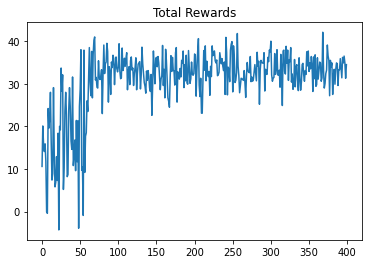

In [11]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

## 測試
在這邊我們替換環境使用的資料日期區間，並使用讀取紀錄點的方式來執行測試。

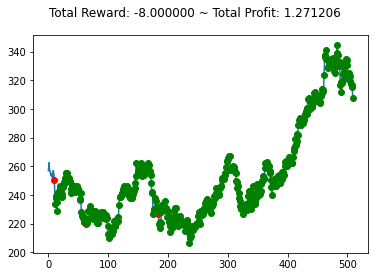

In [12]:
env = MyStocksEnv(df=STOCKS_TSMC, window_size=10, frame_bound=(2000, 2500))

network = PolicyGradientNetwork(env.shape[0] * env.shape[1])
test_agent = PolicyGradientAgent(network)

checkpoint_path = './model.ckpt'

test_agent.load_ckpt(checkpoint_path)
test_agent.network.eval()  # 測試前先將 network 切換為 evaluation 模式

observation = env.reset()
while True:
    action, _ = test_agent.sample(observation)
    observation, reward, done, info = env.step(action)
    if done:
      break

plt.cla()
env.render_all()
plt.show()